In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential 
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
# import package
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
from keras.applications.vgg16 import preprocess_input

In [2]:

# from google drive import files
# from google.colab import drive
# drive.mount('/content/drive')
train_path = "/home/amy890202/2022ML_env/machine-learning-nycu-2022-classification/theSimpsons-train/train"
test_path = "/home/amy890202/2022ML_env/machine-learning-nycu-2022-classification/theSimpsons-test"

In [3]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
origin_datasets = datagen.flow_from_directory(train_path,class_mode="categorical",color_mode = "rgb", batch_size=32,target_size = (224,224))
test_datasets = datagen.flow_from_directory(test_path,class_mode="categorical",color_mode = "rgb",shuffle = "false", batch_size=1,target_size = (224,224))
test_datasets.samples

Found 96929 images belonging to 50 classes.
Found 10791 images belonging to 1 classes.


10791

average character : 1938


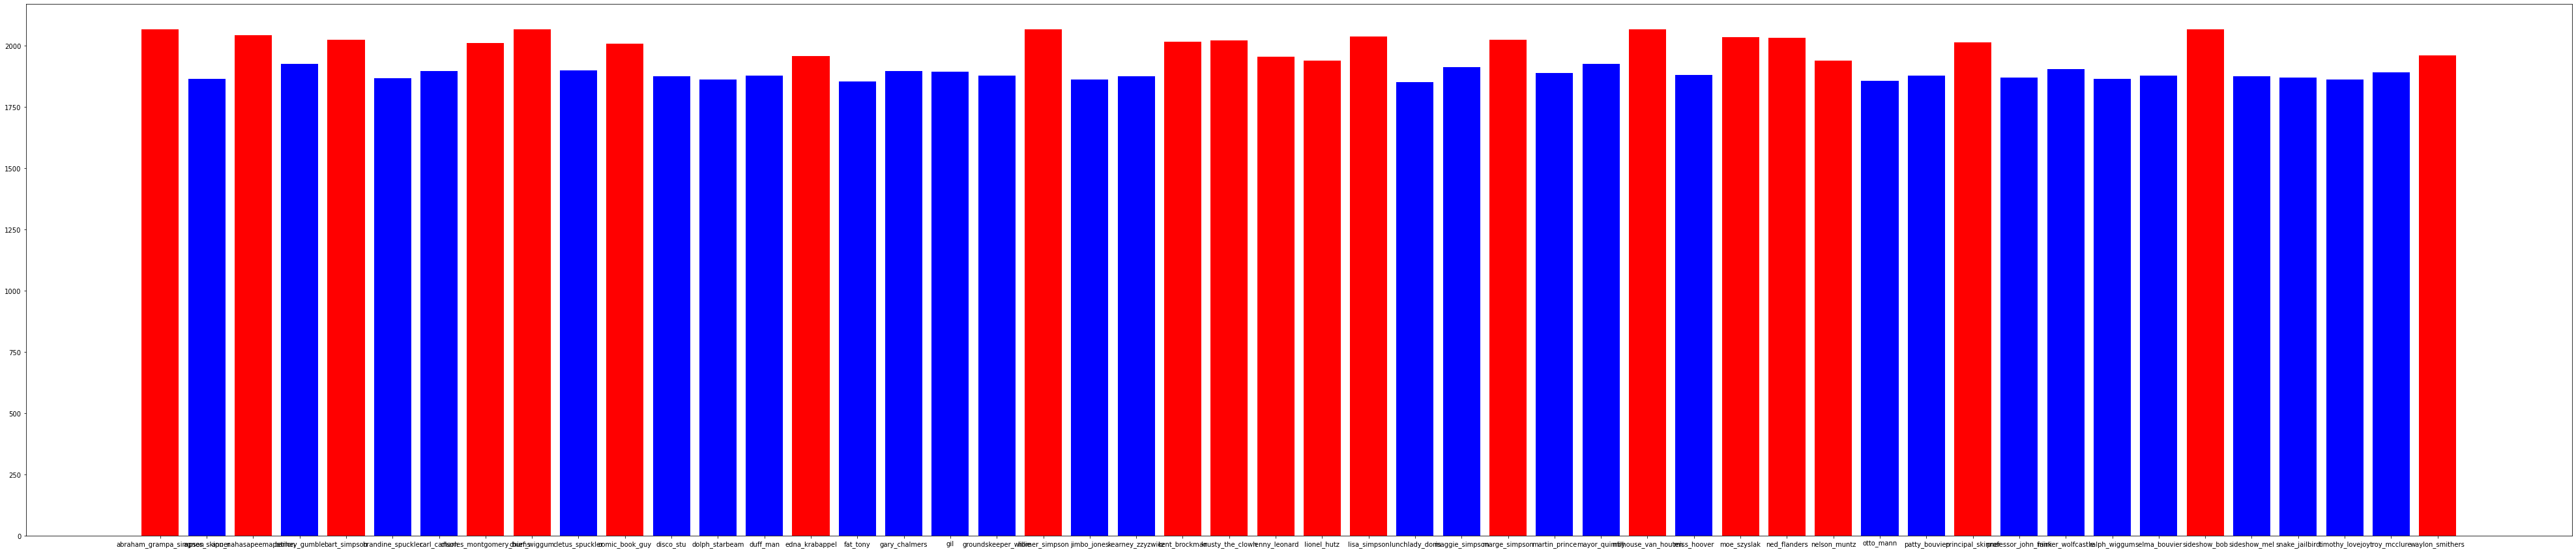

In [4]:
# 查看每位character的數量
chara_count = {}
for data in origin_datasets.filenames:
    chara = data.split('/')[0]
    if chara in chara_count.keys():
        chara_count[chara] += 1
    else:
        chara_count[chara] = 1
print('average character : %i' %(np.mean(list(chara_count.values()))))
#把超過average以上的chara區分出來
color_list = []
chara_list = []
for key,value in zip(chara_count.keys(),chara_count.values()):
    chara_list.append(key)
    if value > 1938 :
        color_list.append('r')
    else:
        color_list.append('b')
# draw bar chart
fig, ax = plt.subplots(figsize=(70, 15))
plt.bar(chara_count.keys(),chara_count.values(),color=color_list)
plt.show()

In [5]:


# Data augmentation for training
train_datagen = ImageDataGenerator(rescale=1. / 255.0,shear_range=0.2,zoom_range=0.2,width_shift_range = 0.2,height_shift_range = 0.2,fill_mode = 'nearest',horizontal_flip=True,preprocessing_function=preprocess_input,validation_split=0.3)

test_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess_input)

train_datasets = train_datagen.flow_from_directory(train_path,class_mode="categorical",color_mode = "rgb", batch_size=32,target_size = (224,224),classes=chara_list,subset='training')
valid_datasets = train_datagen.flow_from_directory(train_path,class_mode="categorical",color_mode = "rgb", batch_size=32,target_size = (224,224),classes=chara_list,subset='validation')




Found 67871 images belonging to 50 classes.
Found 29058 images belonging to 50 classes.


In [7]:
# import numpy as np
# train_x=np.concatenate([train_datasets1.next()[0] for i in range(train_datasets1.__len__())])
# train_y=np.concatenate([train_datasets1.next()[1] for i in range(train_datasets1.__len__())])
# print(train_x.shape)
# print(train_y.shape)
# valid_x=np.concatenate([valid_datasets1.next()[0] for i in range(valid_datasets1.__len__())])
# valid_y=np.concatenate([valid_datasets1.next()[1] for i in range(valid_datasets1.__len__())])
# print(valid_x.shape)
# print(valid_y.shape)


(64964, 256, 256, 3)
(64964, 50)
(31965, 256, 256, 3)
(31965, 50)


In [3]:
# import 套件
from keras.models import Sequential 
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation
from keras.callbacks import EarlyStopping ,ModelCheckpoint, ReduceLROnPlateau

In [7]:
import tensorflow as tf
#tf.__version__
#model = Sequential() #建立一個model
tf.test.is_gpu_available()
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.40
config.gpu_options.allow_growth=True 

In [8]:
#設定early stop
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
# 設定模型儲存條件(儲存最佳模型)
# 設定earlystop條件
#early = EarlyStopping(monitor='val_loss', patience=10,mode='min', verbose=1)
checkpoint = ModelCheckpoint('cnn_checkpoint_vgg16.h5', verbose=1,
                              monitor='val_acc', save_best_only=True,
                              mode='auto')
# 設定lr降低條件(0.001 → 0.005 → 0.0025 → 0.00125 → 下限：0.0001) auto val_acc
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5,
                           patience=5, mode='auto', verbose=1,
                           min_lr=1e-4)

In [9]:
import matplotlib.pyplot as plt
def show_train_history(train_history, train):
    plt.plot(train_history.history[train])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train'], loc='center right')
    plt.show()


In [6]:
from keras.models import Sequential
#import vgg16 model
model = Sequential()
model.add(VGG16(weights = 'imagenet',include_top = False,input_shape = (224,224,3)))
model.add(Flatten())
model.add(Dense(units = 4096,activation = 'relu'))
model.add(Dense(units = 4096,activation = 'relu'))
model.add(Dense(units = len(chara_list) ,activation = 'softmax'))

In [11]:
#construct vgg16 
# from keras.models import Sequential
# from keras.layers import MaxPool2D
# model = Sequential()
# # two conv64 with a pooling layer
# model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# #two conv128 with a pooling layer
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# #conv256 with a pooling layer
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# #four conv512 with a pooling layer
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# #four conv512 with a pooling layer
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# # Two Dense layers with 4096 nodes and an output layer
# model.add(Flatten())
# model.add(Dense(units=4096,activation="relu"))
# model.add(Dense(units=4096,activation="relu"))
# model.add(Dense(units = len(chara_list),activation = 'softmax'))
# #model.add(Dense(units=50, activation="softmax")) 

In [ ]:
#my own cnn model
# model = Sequential()
# model.add(Conv2D(32, (5, 5), input_shape=(224, 224, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(128, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(128))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(50))
# model.add(Activation('softmax'))



In [12]:
#看整個模型
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 256)       295168    
__________

In [13]:
model.compile(loss = "categorical_crossentropy",optimizer = SGD(lr = 0.001),metrics=['accuracy'])
for layer in model.layers:
    layer.trainable = True

In [ ]:


VGG16_history1 = model.fit_generator(train_datasets,epochs=10, verbose=1,steps_per_epoch=train_datasets.samples//32,validation_data=valid_datasets,validation_steps=valid_datasets.samples//32,use_multiprocessing = True,workers = 16 ,callbacks=[checkpoint, early, reduce_lr])


In [10]:
# from keras.models import load_model
# model = load_model("cnn_checkpoint_vgg16.h5")


/home/amy890202/.conda/envs/py36/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [11]:
#model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_3 (Dense)              (None, 50)                204850    
Total params: 134,465,394
Trainable params: 134,465,394
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Freeze core VGG16 layers and train again 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-4:]:
    layer.trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr = 0.001), 
              metrics=['accuracy'])

In [13]:

VGG16_history2 = model.fit_generator(train_datasets,
                   epochs=20, verbose=1,
                   steps_per_epoch=train_datasets.samples//32,
                   validation_data=valid_datasets,
                   validation_steps=valid_datasets.samples//32,
                   callbacks=[checkpoint, early, reduce_lr],use_multiprocessing = True,workers = 16)


Epoch 1/20


/home/amy890202/.conda/envs/py36/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


2120/2120 [==============================] - 485s 229ms/step - loss: 0.0157 - acc: 0.9964 - val_loss: 0.2838 - val_acc: 0.9335

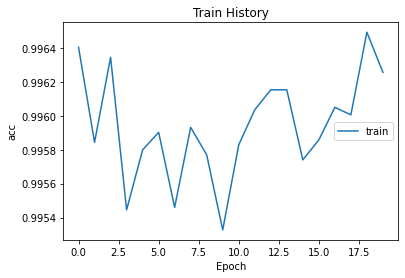

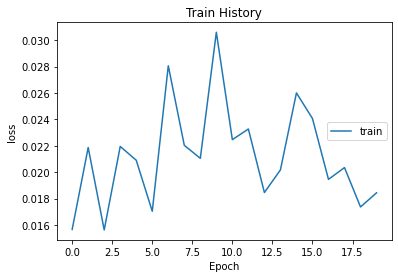

In [14]:
show_train_history(VGG16_history1, 'acc')
show_train_history(VGG16_history1, 'loss')

In [15]:
# # #顯示損失率與正確率

# scores = model.evaluate_generator(valid_datasets,use_multiprocessing=True,workers=10,verbose =0,steps=valid_datasets.samples//32)
# print("loss =",scores[0],",acc = ",scores[1])


/home/amy890202/.conda/envs/py36/lib/python3.6/site-packages/keras/engine/training_generator.py:293: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


loss = 0.20696830116355963 ,acc =  0.9461384911894273


In [16]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
# #from keras.applications.vgg16 import preprocess_input
saveDir = test_path
# #load the image
csv_ans =[]
for i in range(test_datasets.samples):
    img = cv2.imread(saveDir+'/test/'+str(i+1)+'.jpg')
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = preprocess_input(img)
    img = cv2.resize(img,(224,224))
    img = img/255.0
    a = np.reshape(img,(1,224,224,3))
    #make the prediction
    prediction = model.predict(a)
    #(prediction)
    prediction = prediction[0].tolist()
    tmp = max(prediction)
    ans = chara_list[prediction.index(tmp)]
    print(ans)
    csv_ans.append(ans)
# img = img.resize((256, 256))
#         #顯示圖片
#         #img.show()
#         #將圖片轉換為陣列形式，元素為其畫素的亮度值
#         test_img.append(np.asarray(img, dtype=np.float32))
# import numpy as np
# result =[np.round(x) for x in prediction]



gil
disco_stu
patty_bouvier
milhouse_van_houten
lisa_simpson
marge_simpson
lenny_leonard
kearney_zzyzwicz
snake_jailbird
lionel_hutz
ned_flanders
chief_wiggum
chief_wiggum
selma_bouvier
ned_flanders
charles_montgomery_burns
selma_bouvier
krusty_the_clown
gary_chalmers
lionel_hutz
principal_skinner
gary_chalmers
krusty_the_clown
kent_brockman
principal_skinner
sideshow_mel
dolph_starbeam
kent_brockman
bart_simpson
charles_montgomery_burns
carl_carlson
duff_man
edna_krabappel
apu_nahasapeemapetilon
mayor_quimby
jimbo_jones
lisa_simpson
disco_stu
marge_simpson
martin_prince
homer_simpson
homer_simpson
waylon_smithers
maggie_simpson
kent_brockman
maggie_simpson
lisa_simpson
professor_john_frink
rainier_wolfcastle
sideshow_mel
jimbo_jones
waylon_smithers
gary_chalmers
mayor_quimby
nelson_muntz
ralph_wiggum
kearney_zzyzwicz
cletus_spuckler
ralph_wiggum
ned_flanders
maggie_simpson
maggie_simpson
snake_jailbird
mayor_quimby
timothy_lovejoy
brandine_spuckler
lionel_hutz
chief_wiggum
ned_flander

In [17]:
import csv
print(test_datasets.samples)
print(len(csv_ans))
test_id = list(range(1,test_datasets.samples+1))
with open('311581024_t.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'character'])
    for x,y in zip (test_id,csv_ans):
        writer.writerow([x,y])

10791
10791


Found 29058 images belonging to 50 classes.
Confusion Matrix
Normalized confusion matrix
Classification Report
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.86      0.89      0.88       620
           agnes_skinner       0.96      0.96      0.96       559
  apu_nahasapeemapetilon       0.97      0.92      0.94       613
           barney_gumble       0.84      0.95      0.89       577
            bart_simpson       0.95      0.78      0.85       607
       brandine_spuckler       1.00      0.93      0.96       560
            carl_carlson       0.92      0.96      0.94       569
charles_montgomery_burns       0.92      0.90      0.91       603
            chief_wiggum       0.90      0.95      0.93       620
         cletus_spuckler       0.94      0.96      0.95       570
          comic_book_guy       0.95      0.94      0.94       602
               disco_stu       0.96      0.98      0.97       563
          dolph_starbeam      

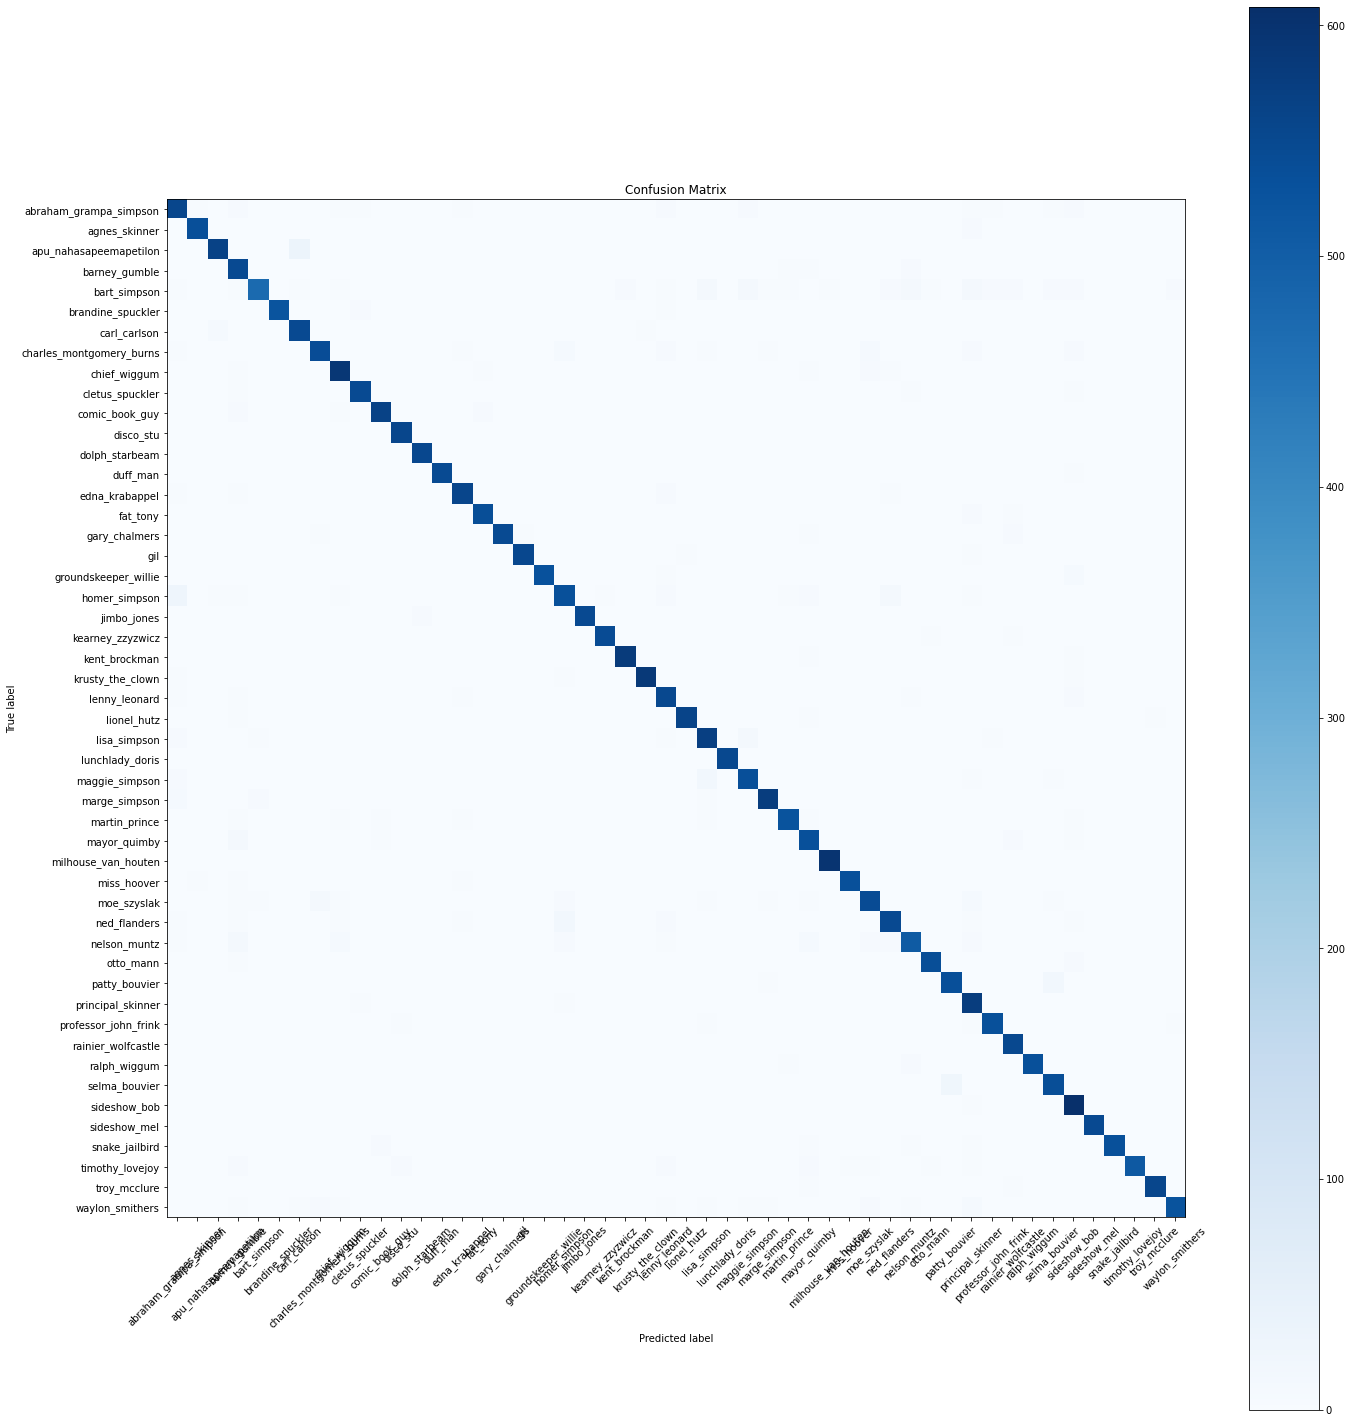

In [18]:
#Plot the confusion matrix. Set Normalize = True/False
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
            horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False
target_names = []
for key in train_datasets.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix
testing_generator = train_datagen.flow_from_directory(train_path,class_mode="categorical",shuffle=False,color_mode = "rgb", batch_size=1,target_size = (224,224),classes=chara_list,subset='validation')


Y_pred = model.predict_generator(testing_generator,steps = testing_generator.samples//1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(testing_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
#Print Classification Report
print('Classification Report')
print(classification_report(testing_generator.classes, y_pred, target_names=target_names))

In [16]:
# summarize filter shapes
for layer in model.layers:
    
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
        
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv2d_3 (3, 3, 3, 64)
conv2d_4 (3, 3, 64, 64)
conv2d_5 (3, 3, 64, 128)
conv2d_6 (3, 3, 128, 128)
conv2d_7 (3, 3, 128, 256)
conv2d_8 (3, 3, 256, 256)
conv2d_9 (3, 3, 256, 256)
conv2d_10 (3, 3, 256, 512)
conv2d_11 (3, 3, 512, 512)
conv2d_12 (3, 3, 512, 512)
conv2d_13 (3, 3, 512, 512)
conv2d_14 (3, 3, 512, 512)
conv2d_15 (3, 3, 512, 512)


In [17]:
# 

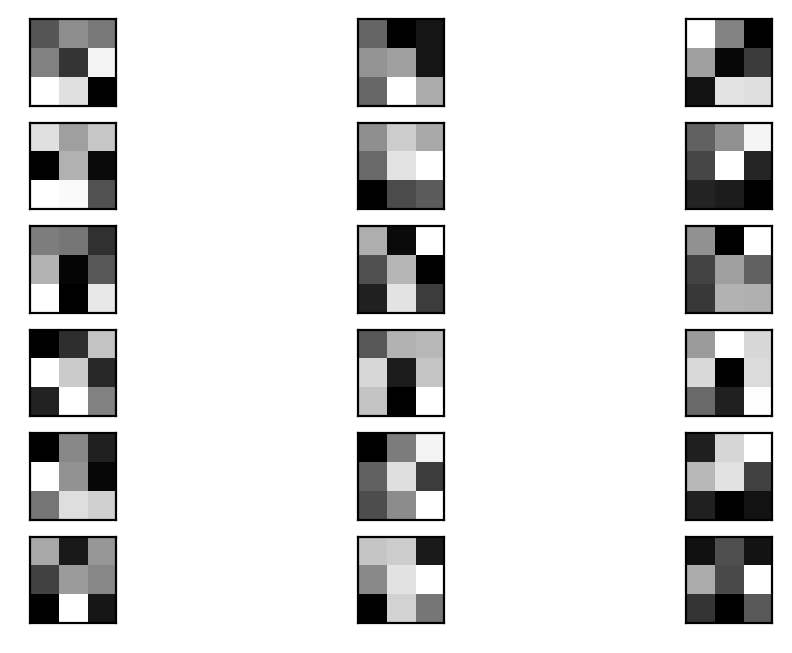

In [15]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

# retrieve weights from the second hidden layer  1->0
filters, biases = model.layers[0].get_weights()  

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray') # coolwarm
        ix += 1
        
# show the figure
plt.show()